# Face Landmarks

Using a subset of [UMD Faces](http://umdfaces.io) database to train a face landmarks predicting model.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
from multiprocessing import Pool
from os.path import join
from pathlib import Path
from copy import deepcopy
import random
import math
import sys

In [3]:
try:
    old_path
except NameError:
    old_path = sys.path
    new_path = [str(Path.cwd()/'loop')] + old_path
    sys.path = new_path

In [4]:
import pandas as pd
import numpy as np
import cv2 as cv
import PIL.Image
from imageio import imread
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm_notebook as tqdm

import torch

In [5]:
from loop import train
from loop.config import defaults
from basedir import DATA, META, CROPPED, NUM_LANDMARKS

/home/ck/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [6]:
SEED = 1
DEVICE = torch.device('cuda:1')
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
defaults.device = DEVICE

---
## Dataset First Glance

In [7]:
meta = pd.read_csv(META)
meta.columns = meta.columns.str.lower()
cols = meta.columns
file_cols = ['subject_id', 'file']
face_cols = cols[cols.str.startswith('face')].tolist()
x_cols = cols[cols.str.startswith('p') & cols.str.endswith('x')].tolist()
y_cols = cols[cols.str.startswith('p') & cols.str.endswith('y')].tolist()
faces_df = meta[file_cols + face_cols + x_cols + y_cols]
faces_df.head()

,subject_id,file,face_x,face_y,face_width,face_height,p1x,p2x,p3x,p4x,...,p12y,p13y,p14y,p15y,p16y,p17y,p18y,p19y,p20y,p21y
0,1,andrew_j_feustel/andrew_j_feustel_0001.jpg,396.10470,115.99280,55.28760,53.28240,406.4610,411.5070,417.1110,428.6170,...,127.0370,140.5620,138.0710,138.8910,138.602,142.3300,147.6620,149.1460,148.159,164.835
1,1,andrew_j_feustel/andrew_j_feustel_0002.jpg,808.97000,218.05190,51.22800,49.00920,814.2580,818.2730,823.3880,834.2550,...,227.0650,245.2970,239.5190,238.9180,238.428,240.4170,248.7770,248.6390,246.979,262.977
2,1,andrew_j_feustel/andrew_j_feustel_0003.jpg,116.16960,82.37583,54.30480,56.21364,120.6950,122.2240,125.1790,132.0140,...,94.0531,110.1360,109.3490,106.9300,108.483,111.0730,119.6780,118.6960,118.978,133.905
3,1,andrew_j_feustel/andrew_j_feustel_0004.jpg,483.74100,213.87210,320.85600,313.16280,552.0410,587.0870,625.0260,693.3090,...,273.0160,350.0050,345.9300,352.6960,347.401,353.7210,402.4170,410.8210,402.350,500.938
4,1,andrew_j_feustel/andrew_j_feustel_0005.jpg,19.08284,52.63863,65.63352,64.68804,30.0739,36.4028,43.5955,58.0033,...,65.4809,83.2004,79.2413,80.0437,79.606,84.1834,91.0663,92.6855,91.236,111.936


In [8]:
def show(i, ax=None):
    global faces_df, DATA
    r = faces_df.loc[i]
    img = imread(DATA/r.file)
    x_pts = [r[k] for k in r.keys() if k[0] == 'p' and k[-1] == 'x']
    y_pts = [r[k] for k in r.keys() if k[0] == 'p' and k[-1] == 'y']
    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(8, 8))
    rc = Rectangle(xy=(r.face_x, r.face_y), 
                   width=r.face_width, height=r.face_height,
                   edgecolor='red', fill=False, lw=5)
    ax.imshow(img)
    ax.scatter(x_pts, y_pts, edgecolor='white', color='lightgreen', alpha=0.8)    
    ax.add_patch(rc)

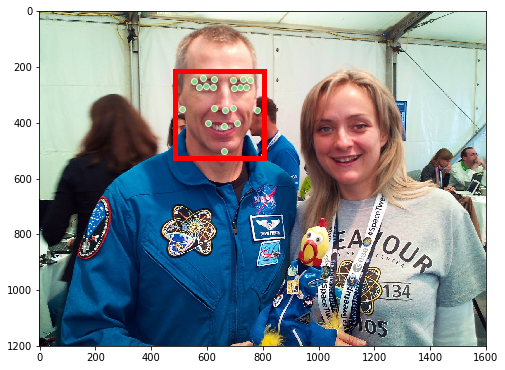

In [9]:
show(3)

In [10]:
def show_grid(n=3, figsize=(10, 10)):
    global faces_df
    f, axes = plt.subplots(n, n, figsize=figsize)
    indicies = np.random.choice(len(faces_df), n ** 2, replace=False)
    for i, ax in zip(indicies, axes.flat):
        show(i, ax=ax)
        ax.set_axis_off()

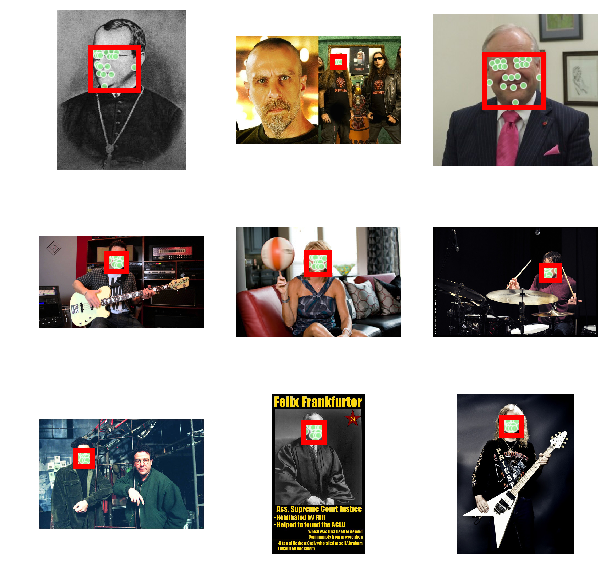

In [11]:
show_grid()

Ok, it seems that each sample includes (at least) one human in various poses with various backgrounds. Therefore, our first goal is to convert this dataset into a more suitable format before we processed with training the model. The most straightforward way to do so is to _crop_ the faces only and save them into smaller files.

---

In [12]:
def split(target):
    return target[:NUM_LANDMARKS//2], target[NUM_LANDMARKS//2:]

In [13]:
def create_dataset_item(info, root):
    """Creates a dictionary with face and landmarks coordinates from data frame record."""
    
    return {
        'subject_id': info.subject_id,
        'image_path': str(root/info.file),
        'x_pos': [info[k] for k in info.keys() if k[0] == 'p' and k[-1] == 'x'],
        'y_pos': [info[k] for k in info.keys() if k[0] == 'p' and k[-1] == 'y'],
        'face': (info.face_x, info.face_y, info.face_width, info.face_height)}

In [14]:
class FaceLandmarks:
    
    def __init__(self, info, root, transforms=None):
        self.transforms = transforms
        self.items = [create_dataset_item(record, DATA) for _, record in meta.iterrows()]
    
    def __len__(self):
        return len(self.items)
    
    def __getitem__(self, item):
        record = self.items[item]
        img = imread(record['image_path'])
        pts = np.array(record['x_pos'] + record['y_pos'], dtype='float32')
        if self.transforms:
            img, pts = self.transforms(img, pts)
        return img, pts

In [15]:
ds = FaceLandmarks(meta, DATA)

In [16]:
test_img, test_pts = ds[3]

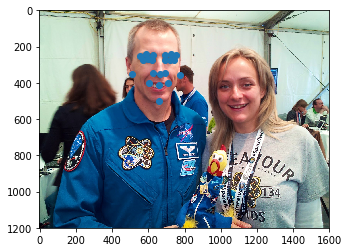

In [17]:
plt.imshow(test_img)
plt.scatter(test_pts[:NUM_LANDMARKS//2], test_pts[NUM_LANDMARKS//2:])

In [18]:
xs, ys = split(test_pts)
l, r, t, b = xs.min(), xs.max(), ys.min(), ys.max()
new_w, new_h = 224, 224
src = np.float32([(l, t), (r, t), (r, b), (l, b)])
dst = np.float32([[0, 0], [new_w-1, 0], [new_w-1, new_h-1], [0, new_h-1]])
m = cv.getPerspectiveTransform(src, dst)

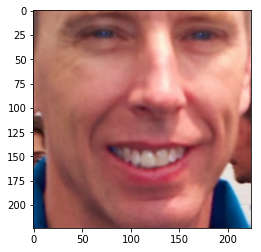

In [19]:
plt.imshow(cv.warpPerspective(test_img, m, (new_w, new_h)), interpolation='bicubic')

In [134]:
def binomial(p):
    return np.random.rand() <= p

In [21]:
def rotation_matrix(x, y=None, angle=5):
    h, w = x.shape[:2]
    minmax = (-angle, angle) if isinstance(angle, int) else angle
    a = np.random.uniform(*minmax)
    m = cv.getRotationMatrix2D((w/2, h/2), a, 1)
    m = np.r_[m, [[0, 0, 1]]]
    return m

In [22]:
def shift_matrix(x, y=None, shift=0.01):
    h, w = x.shape[:2]
    sx, sy = (shift, shift) if isinstance(shift, float) else shift
    shift_x = np.random.randint(-w*sx, w*sx)
    shift_y = np.random.randint(-h*sy, h*sy)
    m = np.float32([
        [1, 0, shift_x],
        [0, 1, shift_y],
        [0, 0, 1]]) 
    return m

In [23]:
def mirror_matrix(x, y=None, horizontal=True):
    h, w = x.shape[:2]
    c1, c2 = (-1, 1) if horizontal else (1, -1)
    s1, s2 = (w, 0) if horizontal else (0, h)
    return np.float32([[c1, 0, s1], [0, c2, s2], [0, 0, 1]])

In [24]:
def perspective_matrix(x, y=None, percentage=(0.05, 0.12)):
    h, w = x.shape[:2]
    
    def rx(): 
        return int(w*np.random.uniform(*percentage))
    
    def ry(): 
        return int(h*np.random.uniform(*percentage))
    
    tl = [0   + rx(), 0   + ry()]
    tr = [w-1 - rx(), 0   + ry()]
    br = [w-1 - rx(), h-1 - ry()]
    bl = [0   + rx(), h-1 - ry()]
    src = np.float32([tl, tr, br, bl])
    dst = np.float32([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])
    m = cv.getPerspectiveTransform(src, dst)
    return m

In [226]:
class CropFace:
    def __init__(self, size=224, pad=10):
        self.size = size
        self.pad = pad
    
    def __call__(self, image, target):
        size = self.size
        xs, ys = split(target)
        x_min, x_max, y_min, y_max = [
            int(pt) for pt in (
                xs.min(), xs.max(), ys.min(), ys.max())]
        x_min -= self.pad
        x_max += self.pad
        y_min -= self.pad
        y_max += self.pad
        cropped = image[y_min:y_max, x_min:x_max]
        xs -= x_min
        ys -= y_min
        new_w, new_h = (size, size) if isinstance(size, int) else size
        old_h, old_w = cropped.shape[:2]
        cropped = cv.resize(cropped, (new_w, new_h))
        rx, ry = new_w/old_w, new_h/old_h
        xs *= rx
        ys *= ry
        return cropped, np.r_[xs, ys]

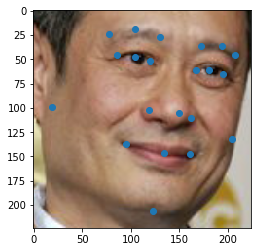

In [230]:
test_img, test_pts = ds[20]
aug_img, aug_pts = CropFace()(test_img, test_pts)
plt.imshow(aug_img)
plt.scatter(*split(aug_pts))

In [231]:
class MatrixAugmentation:
    
    def __init__(self, conf, default_prob=0.5):
        augmentations = {
            'rotation': rotation_matrix,
            'shift': shift_matrix,
            'mirror': mirror_matrix,
            'perspective': perspective_matrix}
        
        pipe = []
        for params in deepcopy(conf):
            name = params.pop('name')
            func = augmentations.get(name)
            if func is None:
                raise ValueError(f'unknown augmentation function: {name}')
            p = params.pop('p', default_prob)
            pipe.append((p, func, params))

        self.pipe = pipe
        
    def __call__(self, image, target=None):
        h, w = image.shape[:2]
        
        m = np.eye(3)
        for p, func, params in self.pipe:
            if binomial(p):
                m = func(image, target, **params) @ m
        
        aug_image = cv.warpPerspective(image, m, (w, h))
        if target is not None:
            new = target.copy()
            n = len(target)//2
            for i in range(n):
                x, y = target[i], target[i + n]
                denom = m[2][0]*x + m[2][1]*y + m[2][2]
                new[i] = (m[0][0]*x + m[0][1]*y + m[0][2])/denom
                new[i + n] = (m[1][0]*x + m[1][1]*y + m[1][2])/denom
            target = new
            
        return aug_image, target

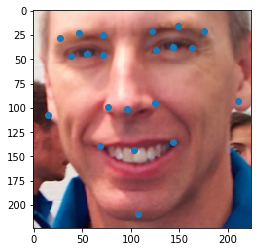

In [244]:
test_img, test_pts = ds[3]
pipe = MatrixAugmentation([
    {'name': 'rotation', 'angle': 10},
    {'name': 'mirror'},
    {'name': 'perspective', 'percentage': (0.05, 0.15)}
])
crop = CropFace(pad=20)
aug_img, aug_pts = pipe(test_img, test_pts)
aug_img, aug_pts = crop(aug_img, aug_pts)
plt.imshow(aug_img)
plt.scatter(aug_pts[:NUM_LANDMARKS//2], aug_pts[NUM_LANDMARKS//2:])

---

## Images Cropping

In [ ]:
def create_meta(unique_id, info, root, output):
    """Creates a dictionary with face and landmarks coordinates from data frame record.
    
    These records with all required meta-information are passed into images generating function.
    
    Args:
        info: Object or namedtuple with information about image.
        root: An absolute path to the folder with annotated images.
        output: Path to the folder where to save processed images.
    
    """
    i = unique_id
    return {
        'index': i,
        'subject_id': info.subject_id,
        'input_path': root/info.file,
        'output_image': output/f'{i}.jpeg',
        'output_points': output/f'{i}.txt',
        'x_pos': [info[k] for k in info.keys() if k[0] == 'p' and k[-1] == 'x'],
        'y_pos': [info[k] for k in info.keys() if k[0] == 'p' and k[-1] == 'y'],
        'face': (info.face_x, info.face_y, info.face_width, info.face_height)
    }

In [ ]:
def as_is(xs, ys, w, h):
    return xs, ys

In [ ]:
def to_centered(xs, ys, w, h):
    return 2*xs/w - 1, 2*ys/h - 1

In [ ]:
def to_absolute(xs, ys, w, h):
    return w*(xs + 1)/2., h*(ys + 1)/2. 

In [ ]:
def crop_image(record, centered=True):
    converter = to_centered if centered else as_is
    x, y, w, h = record['face']
    img = PIL.Image.open(record['input_path'])
    box = x, y, x+w, y+h
    cropped = img.crop(box=box)
    x_pos, y_pos = [np.array(record[k]) for k in ('x_pos', 'y_pos')]
    x_pos, y_pos = converter(x_pos - x, y_pos - y, w, h)
    record.update({'cropped': cropped, 'xy': (x_pos, y_pos), 'centered': centered})
    return record

In [ ]:
def show(record, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 1)
    conv = to_absolute if record['centered'] else as_is
    img = record['cropped']
    h, w = img.size
    ax.imshow(img)
    ax.scatter(*conv(*record['xy'], w, h), color='lightgreen', edgecolor='white', alpha=0.8)
    ax.set_title(record['index'])
    ax.set_axis_off()

In [ ]:
def save_image(record, fmt='%.4f', delimieter=','):
    cropped, (x_pos, y_pos) = record['cropped'], record['xy']
    cropped.save(record['output_image'], format='jpeg')
    np.savetxt(record['output_points'], np.c_[x_pos, y_pos], fmt='%.4f')

In [ ]:
record = create_meta_record(3, meta.loc[3], DATA, CROPPED)
record = crop_image(record)
show(record)

In [ ]:
def read_ordered_files(path, pattern):
    return list(sorted([fn for fn in path.glob(pattern)], key=lambda filename: int(filename.stem)))    

In [ ]:
def create_face_landmarks_dataset(
    input_dir: Path,
    output_dir: Path,
    faces_info: pd.DataFrame
):
    if output_dir.exists():
        print(f'The data is already prepared. Reading from folder: {output_dir}')
        images = [str(x) for x in read_ordered_files(output_dir, '*.jpeg')]
        points = [str(x) for x in read_ordered_files(output_dir, '*.txt')]
        if not images or not points:
            print('Warning: no files in output folder! Delete the folder and try again')
        data = pd.DataFrame({'image': images, 'points': points})
    
    else:
        output_dir.mkdir(parents=True)
        cols = faces_info.columns
        n = len(faces_info)
        print('Running parallel execution pool...')
        worker = partial(create_cropped_image, input_dir=input_dir, output_dir=output_dir)
        with Pool() as pool:
            results = list(pool.imap(worker, tqdm(faces_info.iterrows(), total=n)))
        data = pd.DataFrame(results)
        print(f'Done! Output folder: {output_dir}')
    
    data['order'] = data.image.map(lambda s: int(Path(s).stem))
    data.sort_values(by='order', inplace=True)
    return data

        
def create_cropped_image(item, input_dir, output_dir):
    i, x = item
    record = create_meta(i, x, input_dir, output_dir)
    record = crop_image(record)
    save_image(record)
    return {'image': str(record['output_image']), 'points': str(record['output_points'])}

In [ ]:
landmarks_df = create_face_landmarks_dataset(DATA, CROPPED, meta)